# Aim

Test combined correction based on the stored data generated from combined_correction.ipynb

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, stats, optimize

from observer import *
from aberrations import *

In [2]:
tt = np.load('./combined.npy')
tt_noisy = make_noisy_data(tt, 0.06)

(1e-07, 1376.4850725684007)

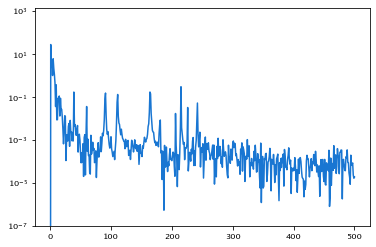

In [3]:
psd = get_psd(tt_noisy[:,0])
plt.semilogy(freqs, psd)
plt.ylim(1e-7)

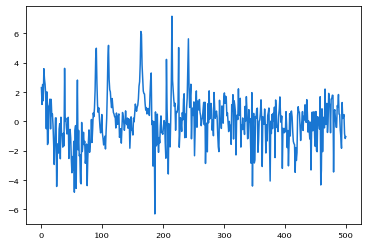

In [4]:
# first, get the fit line
log_freqs, log_power = np.log(freqs[1:]), np.log(psd[1:])
m, b = stats.linregress(log_freqs, log_power)[:2]
plt.plot(freqs[1:], log_power - (m * log_freqs + b))

In [5]:
residual_psd = psd[1:] - np.e**b * freqs[1:]**m

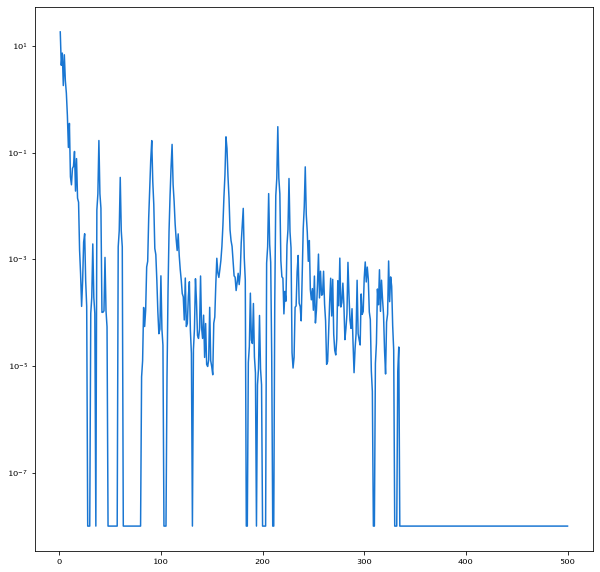

In [6]:
plt.figure(figsize=(10,10))
plt.semilogy(freqs[1:], noise_filter(residual_psd))

In [ ]:
def make_state_transition(params):
    STATE_SIZE = 2 * params.shape[0] + 4
    A = np.zeros((STATE_SIZE, STATE_SIZE))
    for i in range(params.shape[0]):
        f, k = params[i]
        w0 = 2 * np.pi * f / np.sqrt(1 - k**2)
        A[2 * i][2 * i] = 2 *  np.exp(-k * w0 / f_sampling) * np.cos(w0 * np.sqrt(1 - k**2) / f_sampling)
        A[2 * i][2 * i + 1] = -np.exp(-2 * k * w0 / f_sampling)
        A[2 * i + 1][2 * i] = 1
    
    return A

def make_kfilter(params, variances):
    # takes in parameters and variances from which to make a physics simulation
    # and measurements to match it against.
    # returns state, A, P, Q, H, R for kfilter to run.
    A = make_state_transition(params)
    STATE_SIZE = 2 * params.shape[0]
    state = np.zeros(STATE_SIZE)
    H = np.array([[1, 0] * (STATE_SIZE // 2)])
    Q = np.zeros((STATE_SIZE, STATE_SIZE))
    for i in range(variances.size):
        Q[2 * i][2 * i] = variances[i]
    R = measurement_noise * np.identity(1)
    P = np.zeros((STATE_SIZE, STATE_SIZE))
    return state, A, P, Q, H, R

0.05904053013143088


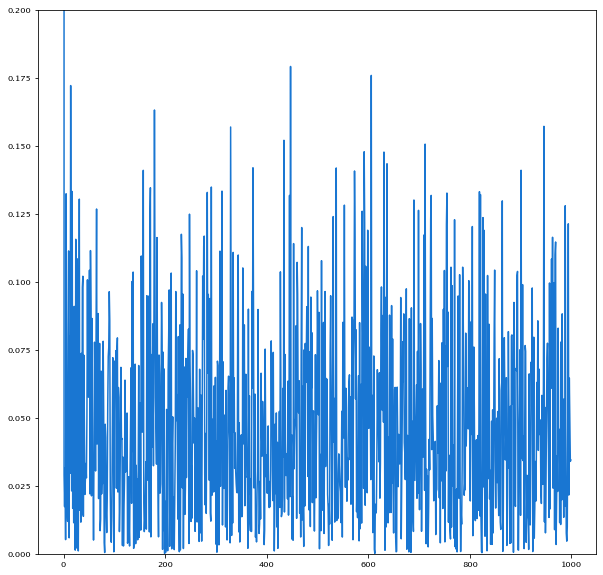

In [10]:
state, A, P, Q, H, R = make_kfilter(*vibe_fit_freq(noise_filter(residual_psd)))
'''variances = [0.0011, 0.0009, 0.001, 0.0013, 0.0795, 0.0686, 0.0138, 0.1073, 0.027, 0.0035]
for i, v in enumerate(variances):
    Q[2*i][2*i] = v'''
pos_freq = kfilter((state, A, P, Q, H, R), tt_noisy[:,0])
plt.figure(figsize=(10,10))
plt.plot(np.abs(pos_freq - tt[:,0]))
plt.ylim(0, 0.2)
print(np.sqrt(np.mean((pos_freq[10:] - tt[:,0][10:])**2)))